In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv('monitoring_2024_dt.csv')

### Příprava dat pro model s využitím perf2_2_12

In [29]:
accepted_data = data.query('perf2_2_12 != "R" and perf2_2_12 != "O" and perf2_2_12 != "I"')
rejected_data = data[data['perf2_2_12'] == "R"]
accepted_data['perf2_2_12'].value_counts()

perf2_2_12
G    16326
B       89
Name: count, dtype: int64

### Distribuce dat

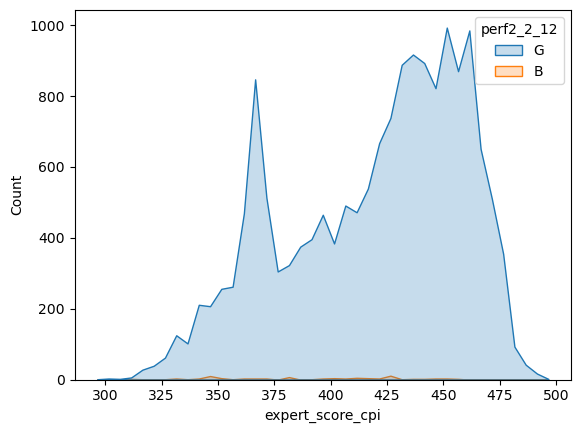

In [28]:
ax = sns.histplot(
    data=accepted_data,
    x="expert_score_cpi",
    hue="perf2_2_12",
    element="poly"
)

#### Výběr proměnných

In [30]:
variables = [
    'CAR_TYPE', 'TERM', 'AGE', 'CB_SCORE', 
    'DISPOSABLE_INCOME_CPI', 'LOAN_TO_VALUE', 
    'MARITAL_STATUS', 'TIME_AT_EMPLOYMENT','expert_score_cpi','perf2_2_12'
]
X = accepted_data[variables]
y = accepted_data['perf2_2_12']

In [31]:
#Transformace y 
# Vytvoření instance OneHotEncoder
encoder = LabelEncoder()
# Přizpůsobení a transformace y pomocí OneHotEncoder
y = encoder.fit_transform(y)
encoder.classes_ 
#0 - B
#1 - G

array(['B', 'G'], dtype=object)

#### Příprava test, train dat

In [32]:
X_train_accepted, X_test_accepted, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [33]:
X_test = X_test_accepted.copy()
X_train = X_train_accepted.copy()
print("Počet záznamů v X_test_accepted:", len(X_test))
print("Počet záznamů v y_test_accepted:", len(y_test))
X_test = X_test.drop(columns=['expert_score_cpi','perf2_2_12'])
X_train = X_train.drop(columns=['expert_score_cpi','perf2_2_12'])

Počet záznamů v X_test_accepted: 4925
Počet záznamů v y_test_accepted: 4925


In [34]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [35]:
X_test_accepted_dummy = X_test.copy()
X_train_accepted_dummy = X_train.copy()

In [36]:
print("Počet záznamů v X_test_accepted:", len(X_test_accepted_dummy))

Počet záznamů v X_test_accepted: 4925


### Model - výpočet

In [37]:
model = {}
model['accepted'] = LogisticRegression(solver='lbfgs', max_iter=1000)
model['accepted'].fit(X_train, y_train)

LogisticRegression(max_iter=1000)

#### Predikce testovací data

In [38]:
y_pred_test = model['accepted'].predict(X_test)
y_prob_test = model['accepted'].predict_proba(X_test)
y_prob_class0_test = y_prob_test[:,0]
y_prob_class1_test = y_prob_test[:,1]
y_test = y_test.astype(float)

#### Predikce train data

In [39]:
y_pred_train = model['accepted'].predict(X_train)
y_prob_train = model['accepted'].predict_proba(X_train)
y_prob_class0_train = y_prob_train[:,0]
y_prob_class1_train = y_prob_train[:,1]
y_train = y_train.astype(float)

### Performance metriky

##### test data

In [40]:
auc_score = roc_auc_score(y_test, y_prob_class1_test)
gini_test = auc_score*2-1
gini_test

0.6536454788802688

##### train data

In [41]:
auc_score = roc_auc_score(y_train, y_prob_class1_train)
gini_train = auc_score*2-1
gini_train

0.685811306694367

### Fuzzy Augmentation

#### Predikce u rejects

In [49]:
features = [
    'CAR_TYPE', 'TERM', 'AGE', 'CB_SCORE', 
    'DISPOSABLE_INCOME_CPI', 'LOAN_TO_VALUE', 
    'MARITAL_STATUS', 'TIME_AT_EMPLOYMENT'
]
rejected_data_transformed = pd.get_dummies(rejected_data[features], columns=features)
ScoresRejects = model['accepted'].predict_proba(rejected_data_transformed)
rejected_data.loc[:,'Good_Prob'] = ScoresRejects[:, list(model['accepted'].classes_).index(1)]
rejected_data.loc[:,'Bad_Prob'] = ScoresRejects[:, list(model['accepted'].classes_).index(0)]
rejected_data.head()

,application_id,created_date,CAR_TYPE,TERM,AGE,CB_SCORE,DISPOSABLE_INCOME_CPI,LOAN_TO_VALUE,MARITAL_STATUS,TIME_AT_EMPLOYMENT,expert_score_cpi,perf2_2_12,perf2_3_12,Good_Prob,Bad_Prob
0,20450088,2023-03-20,B Toyota New,D > 48 - < High,E Missing,B Low - <= 365 + Already Bad,E Missing,B > 0.75 - <= 0.88,D Missing,F Missing,306,R,R,0.997899,0.002101
1,20452461,2022-06-23,E Used more than 4 years,"B 36, 37",D > 51 - <= High,B Low - <= 365 + Already Bad,E Missing,C > 0.88 - < High,"B Single, Widowed",F Missing,339,R,R,0.985748,0.014252
2,20452463,2023-03-20,E Used more than 4 years,C > 37 - <= 48,D > 51 - <= High,B Low - <= 365 + Already Bad,B > 2150 - <= 2650,A Low - <= 0.75,C Married / Civil Partnership,D > 120 - <= 240,373,R,R,0.996518,0.003482
3,20456215,2023-01-17,B Toyota New,"B 36, 37",D > 51 - <= High,B Low - <= 365 + Already Bad,C > 2650 - <= 3850,B > 0.75 - <= 0.88,C Married / Civil Partnership,D > 120 - <= 240,394,R,R,0.997161,0.002839
4,20458346,2023-01-17,B Toyota New,C > 37 - <= 48,E Missing,B Low - <= 365 + Already Bad,E Missing,A Low - <= 0.75,D Missing,F Missing,328,R,R,0.999147,0.000853


In [51]:
rejected_bad = rejected_data.copy()
rejected_bad['Performance'] = 0
rejected_bad['Weight'] = rejected_bad['Bad_Prob']

rejected_good = rejected_data.copy()
rejected_good['Performance'] = 1
rejected_good['Weight'] = rejected_good['Good_Prob']
RejectsTable = pd.concat([rejected_bad, rejected_good], ignore_index=True)

In [52]:
RejectsTable.head()

,application_id,created_date,CAR_TYPE,TERM,AGE,CB_SCORE,DISPOSABLE_INCOME_CPI,LOAN_TO_VALUE,MARITAL_STATUS,TIME_AT_EMPLOYMENT,expert_score_cpi,perf2_2_12,perf2_3_12,Good_Prob,Bad_Prob,Performance,Weight
0,20450088,2023-03-20,B Toyota New,D > 48 - < High,E Missing,B Low - <= 365 + Already Bad,E Missing,B > 0.75 - <= 0.88,D Missing,F Missing,306,R,R,0.997899,0.002101,0,0.002101
1,20452461,2022-06-23,E Used more than 4 years,"B 36, 37",D > 51 - <= High,B Low - <= 365 + Already Bad,E Missing,C > 0.88 - < High,"B Single, Widowed",F Missing,339,R,R,0.985748,0.014252,0,0.014252
2,20452463,2023-03-20,E Used more than 4 years,C > 37 - <= 48,D > 51 - <= High,B Low - <= 365 + Already Bad,B > 2150 - <= 2650,A Low - <= 0.75,C Married / Civil Partnership,D > 120 - <= 240,373,R,R,0.996518,0.003482,0,0.003482
3,20456215,2023-01-17,B Toyota New,"B 36, 37",D > 51 - <= High,B Low - <= 365 + Already Bad,C > 2650 - <= 3850,B > 0.75 - <= 0.88,C Married / Civil Partnership,D > 120 - <= 240,394,R,R,0.997161,0.002839,0,0.002839
4,20458346,2023-01-17,B Toyota New,C > 37 - <= 48,E Missing,B Low - <= 365 + Already Bad,E Missing,A Low - <= 0.75,D Missing,F Missing,328,R,R,0.999147,0.000853,0,0.000853


#### Spojení s accepted daty

In [87]:
X_train_accepted.loc[:,'Weight'] = 1
X_train_accepted.loc[:,'Performance'] = X_train_accepted.loc[:,'perf2_2_12'].apply(lambda x: 0 if x=="B" else 1)
CombinedData = pd.concat([X_train_accepted, RejectsTable], ignore_index=True)

In [88]:
CombinedData.head()

,CAR_TYPE,TERM,AGE,CB_SCORE,DISPOSABLE_INCOME_CPI,LOAN_TO_VALUE,MARITAL_STATUS,TIME_AT_EMPLOYMENT,expert_score_cpi,perf2_2_12,Weight,Performance,application_id,created_date,perf2_3_12,Good_Prob,Bad_Prob
0,B Toyota New,D > 48 - < High,D > 51 - <= High,E > 511 - < High,D > 3850 - < High,A Low - <= 0.75,C Married / Civil Partnership,E > 240 - < High,456,G,1.0,1,NaN,NaN,NaN,NaN,NaN
1,B Toyota New,A Low - <= 35,B > 32 -<= 37,B Low - <= 365 + Already Bad,A Low - <= 2150,A Low - <= 0.75,"B Single, Widowed",A Low - <= 24,366,G,1.0,1,NaN,NaN,NaN,NaN,NaN
2,D Used 3 to 4 years,"B 36, 37",A Low - <= 32,B Low - <= 365 + Already Bad,E Missing,A Low - <= 0.75,"B Single, Widowed",F Missing,337,G,1.0,1,NaN,NaN,NaN,NaN,NaN
3,E Used more than 4 years,D > 48 - < High,A Low - <= 32,B Low - <= 365 + Already Bad,A Low - <= 2150,A Low - <= 0.75,"B Single, Widowed",C > 48 - <= 120,318,G,1.0,1,NaN,NaN,NaN,NaN,NaN
4,B Toyota New,D > 48 - < High,C > 37 - <= 51,E > 511 - < High,C > 2650 - <= 3850,B > 0.75 - <= 0.88,C Married / Civil Partnership,E > 240 - < High,445,G,1.0,1,NaN,NaN,NaN,NaN,NaN


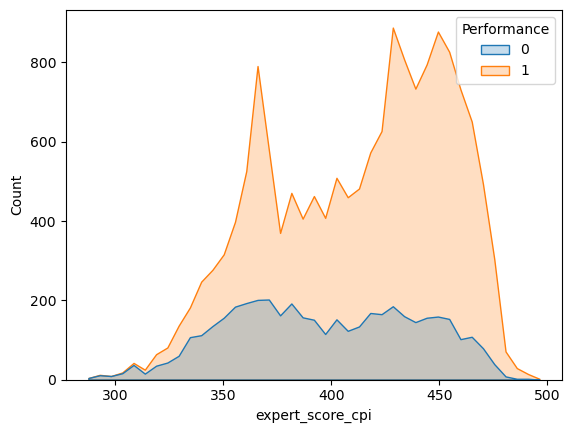

In [89]:
ax = sns.histplot(
    data=CombinedData,
    x="expert_score_cpi",
    hue="Performance",
    element="poly"
)

### Nový model s rejected daty

#### Příprava dat

In [90]:
variables = [
    'CAR_TYPE', 'TERM', 'AGE', 'CB_SCORE', 
    'DISPOSABLE_INCOME_CPI', 'LOAN_TO_VALUE', 
    'MARITAL_STATUS', 'TIME_AT_EMPLOYMENT'
]
X_for_fuzzy = CombinedData[variables]
y_for_fuzzy = CombinedData['Performance']
sample_weights = CombinedData['Weight']
X_for_fuzzy = pd.get_dummies(X_for_fuzzy)

In [91]:
y_for_fuzzy = y_for_fuzzy.astype(int)

#### Výpočet modelu

In [92]:
model['fuzzy'] = LogisticRegression(solver='lbfgs', max_iter=1000)
model['fuzzy'].fit(X_for_fuzzy, y_for_fuzzy, sample_weight=sample_weights)

LogisticRegression(max_iter=1000)

#### predikce

In [100]:
#predikce
y_pred_fuzzy = model['fuzzy'].predict(X_test)
y_prob_combined = model['fuzzy'].predict_proba(X_test_accepted_dummy)
y_prob_class1_combined = y_prob_combined[:,1]

#### Performance metriky

In [68]:
print("Classification Report:\n", classification_report(y_test, y_pred_fuzzy, zero_division = 0))

Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        27
         1.0       0.99      1.00      1.00      4898

    accuracy                           0.99      4925
   macro avg       0.50      0.50      0.50      4925
weighted avg       0.99      0.99      0.99      4925



In [101]:
auc_score = roc_auc_score(y_test, y_prob_class1_combined)
gini = auc_score*2-1
gini

0.6501066194818748

#### Vizualizace

In [94]:
bins = [-float('inf'), 358, 373, 386, 396, 408, 419, 434, 447, 461, float('inf')]
labels = ["<=358", "359 - 373", "374 - 386", "387 - 396", "397 - 408", "409 - 419",
          "420 - 434", "435 - 447", "448 - 461", ">=462"]
CombinedData.loc[:,'score_category'] = pd.cut(CombinedData.loc[:,'expert_score_cpi'], bins=bins, labels=labels)
accepted_data.loc[:,'score_category'] = pd.cut(accepted_data.loc[:,'expert_score_cpi'], bins=bins, labels=labels)

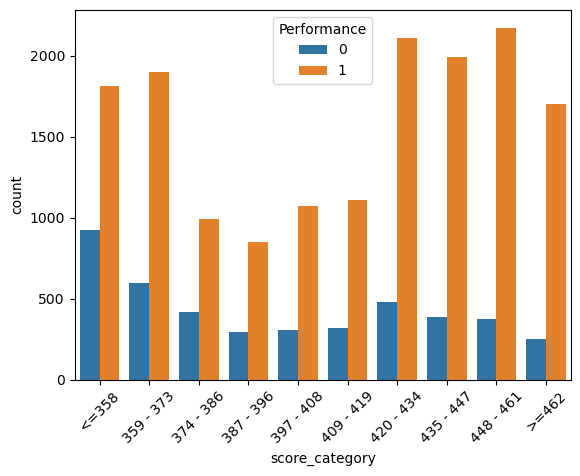

In [95]:
ax = sns.countplot(
    data=CombinedData,
    x="score_category",
    hue="Performance"
)
ax.tick_params(axis="x", rotation=45)

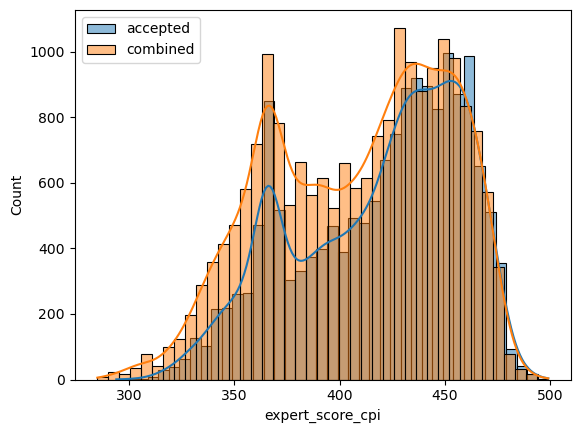

In [96]:
sns.histplot(data=accepted_data['expert_score_cpi'], label = "accepted", kde=True)
sns.histplot(data=CombinedData['expert_score_cpi'], label = "combined", kde=True)
plt.legend()
plt.show()

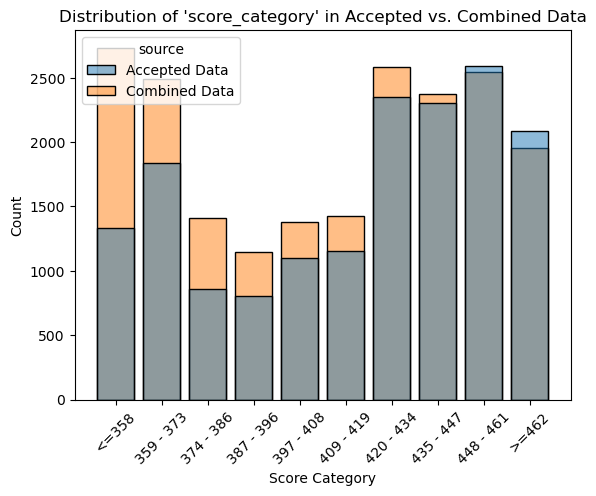

In [97]:
accepted_data.loc[:,'source'] = 'Accepted Data'
CombinedData.loc[:,'source'] = 'Combined Data'
plot_data = pd.concat([accepted_data, CombinedData], ignore_index=True)
labels = ["<=358", "359 - 373", "374 - 386", "387 - 396", "397 - 408", "409 - 419",
          "420 - 434", "435 - 447", "448 - 461", ">=462"]
plot_data.loc[:,'score_category'] = pd.Categorical(
    plot_data['score_category'], 
    categories=labels, 
    ordered=True
)
sns.histplot(data=plot_data, x='score_category', hue='source',shrink=0.8, alpha = 0.5)
plt.title("Distribution of 'score_category' in Accepted vs. Combined Data")
plt.xlabel("Score Category")
plt.xticks(rotation=45)
plt.show()